In [116]:
import numpy as np
from scipy.stats import dirichlet
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import truncnorm
from scipy.stats import gamma

def an_post(index, hm, xt, alpha):
    w0x = np.arange(1e-6, 1, 1/hm)
    x = tqdm.tqdm( w0x)
    w0y = []
    for w0 in x:
        w1x = np.arange(1e-6, 1-w0, 1/hm)
        w1y = []
        for w1 in w1x:
            w2 = 1-w0-w1
            if index == 0: w1y.append( np.exp( log_posterior(xt, np.array([w0, w1, w2]), alpha  ) ) ) 
            elif index == 1: w1y.append( np.exp( log_posterior(xt, np.array([w1, w0, w2]), alpha  ) ) ) 
            else: w1y.append( np.exp( log_posterior(xt, np.array([w2, w1, w0]), alpha  ) ) ) 
        w0y.append( np.trapz( np.array(w1y), w1x) )
    y = np.array(w0y)
    return w0x, y/np.trapz(y, w0x)

def generate_xt(n_pars, hm):
    xt = []
    for _ in range(hm):
        temp = np.linspace(10,1,n_pars) * np.random.uniform(0,1,n_pars)
        xt.append(temp/np.sum(temp))
    return np.array(xt)

def loglikelihood(xt, omega):
    return np.sum( np.log( np.array( [ np.sum(xt[i]*omega) for i in range(len(xt)) ] ) ) )

def log_posterior(xt, omega, alpha):
    return loglikelihood(xt, omega) + dirichlet.logpdf(omega, alpha = alpha)

def sampling(n, xt, alpha):
    accepted = []
    c = 0
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    omega = np.hstack( dirichlet.rvs(alpha = alpha, size = 1) )
    for i in pb:
        acp = i and c/i or 0
        pb.set_description("Acceptance rate %f" % acp)
        omega_new = np.hstack( dirichlet.rvs(alpha = alpha, size = 1) )
        if log_rnd[i] <= log_acceptance_diri(xt, alpha, omega, omega_new):
            omega = omega_new
            c +=1
            accepted.append(omega)
    return np.array(accepted)

def sampling2(n, xt, alpha, eps, each):
    #myclip_a = 0
    #myclip_b = 1e6
    #scale = eps
    #sigma = np.ones(len(alpha))*eps
    accepted = []
    c = 0
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    x = np.ones(len(alpha)) * len(alpha) *10
    #x = np.random.normal(0,scale,len(alpha))
    omega = x/np.sum(x)
    for i in pb:
        acp = i and c/i or 0
        pb.set_description("Acceptance rate %f" % acp)
        #a, b = (myclip_a - x) / scale, (myclip_b - x) / scale
        #x_new = truncnorm.rvs(a, b, loc=x, scale=scale)
        mu = x
        sigma = eps * x
        scale = sigma**2/mu
        a = mu**2/sigma**2
        x_new = gamma.rvs(a, scale = scale)
        omega_new = x_new/np.sum(x_new)
        if i % each == 0: print(x_new)
        if log_rnd[i] <= log_acceptance(xt, alpha, x, x_new, omega, omega_new, eps):
            omega = omega_new
            x = x_new
            c +=1
            accepted.append(omega)
    return np.array(accepted)

def log_acceptance_diri(xt, alpha, omega, omega_new):
    return log_posterior(xt, omega_new, alpha) - log_posterior(xt, omega, alpha) + dirichlet.logpdf(omega_new, alpha = alpha) - dirichlet.logpdf(omega, alpha = alpha)

def log_acceptance(xt, alpha, x, x_new, omega, omega_new, eps):
            mu_old = x
            sigma_old = x*eps
            scale_old = sigma_old**2/mu_old
            a_old = mu_old**2/sigma_old**2
            mu_new = x_new
            sigma_new = eps * x_new
            scale_new = sigma_new**2/mu_new
            a_new = mu_new**2/sigma_new**2
            return log_posterior(xt, omega_new, alpha) - log_posterior(xt, omega, alpha) + log_jacobian(x_new) - log_jacobian(x) + norm.logpdf(np.sum(x_new), loc = 0, scale = 1) - norm.logpdf(np.sum(x), loc = 0, scale = 1) - np.sum( gamma.logpdf(x_new, a = a_old, scale=scale_old) ) + np.sum( gamma.logpdf(x, a = a_new, scale=scale_new) )

def log_jacobian(x):
    return -(len(x)) * np.log(np.sum(x))



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[8.20607593e+00 4.45080325e-02]
 [6.58817104e+00 4.68385111e-03]
 [1.45508655e+01 5.16819658e-03]
 ...
 [9.82701449e+00 1.55220599e-13]
 [1.04163915e+01 1.36406156e-01]
 [6.65329009e+00 9.21732255e-01]]


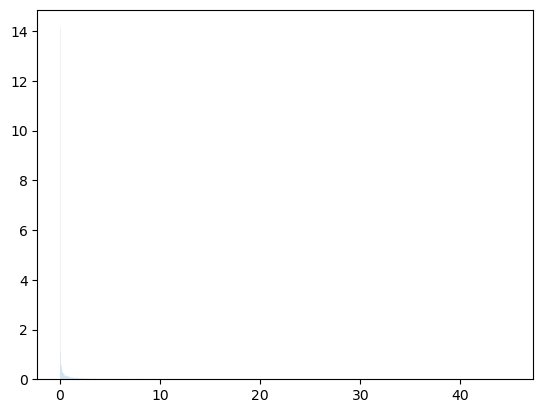

0.9929301260106271
2.9741980937107906


array([-2.0308701 ,  0.37448511])

In [117]:
mu = np.array([10,1])
sigma = np.ones(2)*3

scale = sigma**2/mu
a = mu**2/sigma**2

ri = gamma.rvs(a, scale = scale, size = [10000,2])
print(ri)
r = ri[:,1]
fig, ax = plt.subplots(1, 1)
ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
#ax.set_xlim([x[0], x[-1]])
ax.legend(loc='best', frameon=False)
plt.show()

print(np.mean(r))
print(np.sqrt(np.mean(r**2)-np.mean(r)**2))

gamma.logpdf(ri[0], a = a, scale=scale)

In [118]:
def w1_post(w1arr, alpha, xt):
    a1,a2,a3 = alpha
    x1,y1,z1 = xt[0]
    x2,y2,z2 = xt[1]
    x3,y3,z3 = xt[2]
    y = []
    for w1 in w1arr:
        y.append( ((1-w1)**(-1+a2+a3)*w1**(-1+a1)*(-a2*(1+a2)*(2+a2)*(-1+w1)**3*y1*y2*y3+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y2*y3*(x1-z1)+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y2*y3*z1+a2*(1+a2)*(2+a2)*(-1+w1)**3*y2*y3*z1+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y1*y3*(x2-z2)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*y3*(x1-z1)*(x2-z2)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y3*z1*(x2-z2)-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y3*z1*(x2-z2)+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y1*y3*z2+a2*(1+a2)*(2+a2)*(-1+w1)**3*y1*y3*z2-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y3*(x1-z1)*z2-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y3*(x1-z1)*z2-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*y3*z1*z2-2*a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y3*z1*z2-a2*(1+a2)*(2+a2)*(-1+w1)**3*y3*z1*z2+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y1*y2*(x3-z3)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*y2*(x1-z1)*(x3-z3)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y2*z1*(x3-z3)-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y2*z1*(x3-z3)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*y1*(x2-z2)*(x3-z3)+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1**3*(x1-z1)*(x2-z2)*(x3-z3)+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1**2*z1*(x2-z2)*(x3-z3)+a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*z1*(x2-z2)*(x3-z3)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y1*z2*(x3-z3)-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y1*z2*(x3-z3)+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1**2*(x1-z1)*z2*(x3-z3)+a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*(x1-z1)*z2*(x3-z3)+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1*z1*z2*(x3-z3)+2*a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*z1*z2*(x3-z3)+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*z1*z2*(x3-z3)+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y1*y2*z3+a2*(1+a2)*(2+a2)*(-1+w1)**3*y1*y2*z3-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y2*(x1-z1)*z3-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y2*(x1-z1)*z3-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*y2*z1*z3-2*a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y2*z1*z3-a2*(1+a2)*(2+a2)*(-1+w1)**3*y2*z1*z3-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y1*(x2-z2)*z3-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y1*(x2-z2)*z3+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1**2*(x1-z1)*(x2-z2)*z3+a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*(x1-z1)*(x2-z2)*z3+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1*z1*(x2-z2)*z3+2*a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*z1*(x2-z2)*z3+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*z1*(x2-z2)*z3-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*y1*z2*z3-2*a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y1*z2*z3-a2*(1+a2)*(2+a2)*(-1+w1)**3*y1*z2*z3+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1*(x1-z1)*z2*z3+2*a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*(x1-z1)*z2*z3+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*(x1-z1)*z2*z3+(a2+a3)*(1+a2+a3)*(2+a2+a3)*z1*z2*z3+3*a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*z1*z2*z3+3*a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*z1*z2*z3+a2*(1+a2)*(2+a2)*(-1+w1)**3*z1*z2*z3))/((a2+a3)*(1+a2+a3)*(2+a2+a3)) )
    y = np.array(y)
    return y/np.trapz(y,w1arr)

def w2_post(w2arr, alpha, xt):
    a1,a2,a3 = alpha
    x1,y1,z1 = xt[0]
    x2,y2,z2 = xt[1]
    x3,y3,z3 = xt[2]
    y = []
    for w2 in w2arr:
        y.append( ((1-w2)**(-1+a1+a3)*w2**(-1+a2)*(-a1*(1+a1)*(2+a1)*(-1+w2)**3*x1*x2*x3+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x2*x3*(y1-z1)+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x2*x3*z1+a1*(1+a1)*(2+a1)*(-1+w2)**3*x2*x3*z1+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x1*x3*(y2-z2)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*x3*(y1-z1)*(y2-z2)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x3*z1*(y2-z2)-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x3*z1*(y2-z2)+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x1*x3*z2+a1*(1+a1)*(2+a1)*(-1+w2)**3*x1*x3*z2-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x3*(y1-z1)*z2-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x3*(y1-z1)*z2-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*x3*z1*z2-2*a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x3*z1*z2-a1*(1+a1)*(2+a1)*(-1+w2)**3*x3*z1*z2+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x1*x2*(y3-z3)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*x2*(y1-z1)*(y3-z3)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x2*z1*(y3-z3)-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x2*z1*(y3-z3)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*x1*(y2-z2)*(y3-z3)+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2**3*(y1-z1)*(y2-z2)*(y3-z3)+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2**2*z1*(y2-z2)*(y3-z3)+a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*z1*(y2-z2)*(y3-z3)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x1*z2*(y3-z3)-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x1*z2*(y3-z3)+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2**2*(y1-z1)*z2*(y3-z3)+a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*(y1-z1)*z2*(y3-z3)+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2*z1*z2*(y3-z3)+2*a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*z1*z2*(y3-z3)+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*z1*z2*(y3-z3)+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x1*x2*z3+a1*(1+a1)*(2+a1)*(-1+w2)**3*x1*x2*z3-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x2*(y1-z1)*z3-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x2*(y1-z1)*z3-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*x2*z1*z3-2*a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x2*z1*z3-a1*(1+a1)*(2+a1)*(-1+w2)**3*x2*z1*z3-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x1*(y2-z2)*z3-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x1*(y2-z2)*z3+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2**2*(y1-z1)*(y2-z2)*z3+a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*(y1-z1)*(y2-z2)*z3+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2*z1*(y2-z2)*z3+2*a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*z1*(y2-z2)*z3+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*z1*(y2-z2)*z3-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*x1*z2*z3-2*a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x1*z2*z3-a1*(1+a1)*(2+a1)*(-1+w2)**3*x1*z2*z3+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2*(y1-z1)*z2*z3+2*a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*(y1-z1)*z2*z3+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*(y1-z1)*z2*z3+(a1+a3)*(1+a1+a3)*(2+a1+a3)*z1*z2*z3+3*a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*z1*z2*z3+3*a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*z1*z2*z3+a1*(1+a1)*(2+a1)*(-1+w2)**3*z1*z2*z3))/((a1+a3)*(1+a1+a3)*(2+a1+a3)) )
    y = np.array(y)
    return y/np.trapz(y,w2arr)

def w3_post(w3arr, alpha, xt):
    a1,a2,a3 = alpha
    x1,y1,z1 = xt[0]
    x2,y2,z2 = xt[1]
    x3,y3,z3 = xt[2]
    y = []
    for w3 in w3arr:
        y.append( -(((1-w3)**(-1+a1+a2)*w3**(-1+a3)*(a1**3*((-1+w3)*x1-w3*z1)*((-1+w3)*x2-w3*z2)*((-1+w3)*x3-w3*z3)+a2*(2+3*a2+a2**2)*((-1+w3)*y1-w3*z1)*((-1+w3)*y2-w3*z2)*((-1+w3)*y3-w3*z3)+a1**2*(-3*w3*z1*((-1+w3)*x2-w3*z2)*((-1+w3)*x3-w3*z3)+(-1+w3)*x1*(a2*(-1+w3)*x3*((-1+w3)*y2-w3*z2)+3*w3*z2*(x3-w3*x3+w3*z3)+(-1+w3)*x2*(3*(-1+w3)*x3+a2*(-1+w3)*y3-3*w3*z3-a2*w3*z3)+a2*w3*(y3*(z2-w3*z2)+(y2-w3*y2+2*w3*z2)*z3))+a2*((-1+w3)*x2*((-1+w3)*x3*((-1+w3)*y1-w3*z1)+w3*(y3*(z1-w3*z1)+(y1-w3*y1+2*w3*z1)*z3))-w3*((-1+w3)*x3*((-1+w3)*y2*z1+(-1+w3)*y1*z2-2*w3*z1*z2)+w3*(-((-1+w3)*y3*z1*z2)+y2*(z1-w3*z1)*z3+(y1-w3*y1+3*w3*z1)*z2*z3))))+a1*(-2*w3*z1*((-1+w3)*x2-w3*z2)*((-1+w3)*x3-w3*z3)+(-1+w3)*x1*(a2**2*((-1+w3)*y2-w3*z2)*((-1+w3)*y3-w3*z3)+2*w3*z2*(x3-w3*x3+w3*z3)+(-1+w3)*x2*(2*(-1+w3)*x3+a2*(-1+w3)*y3-2*w3*z3-a2*w3*z3)+a2*((-1+w3)*x3*((-1+w3)*y2-w3*z2)+(-1+w3)*y2*((-1+w3)*y3-2*w3*z3)+w3*z2*(-2*(-1+w3)*y3+3*w3*z3)))+a2*((-1+w3)*x3*((-1+w3)*y1*((-1+w3)*y2-2*w3*z2)+w3*z1*(-2*(-1+w3)*y2+3*w3*z2))+(-1+w3)*x2*((-1+w3)*x3*((-1+w3)*y1-w3*z1)+(-1+w3)*y1*((-1+w3)*y3-2*w3*z3)+w3*z1*(-2*(-1+w3)*y3+3*w3*z3))-w3*((-1+w3)*y2*((-1+w3)*y3*z1+(-1+w3)*y1*z3-3*w3*z1*z3)+z2*((-1+w3)*y1*((-1+w3)*y3-3*w3*z3)+3*w3*z1*(y3-w3*y3+2*w3*z3))))+a2**2*((-1+w3)*x3*((-1+w3)*y1-w3*z1)*((-1+w3)*y2-w3*z2)+(-1+w3)*x2*((-1+w3)*y1-w3*z1)*((-1+w3)*y3-w3*z3)-w3*((-1+w3)*y2*((-1+w3)*y3*z1+(-1+w3)*y1*z3-2*w3*z1*z3)+z2*((-1+w3)*y1*((-1+w3)*y3-2*w3*z3)+w3*z1*(-2*(-1+w3)*y3+3*w3*z3)))))))/((a1+a2)*(1+a1+a2)*(2+a1+a2))) )
    y = np.array(y)
    return y/np.trapz(y,w3arr)

In [119]:
n_pars = 3
hm = 3
xt = generate_xt(n_pars, hm)
print(xt)

[[0.62958063 0.29288528 0.0775341 ]
 [0.49560908 0.40916659 0.09522433]
 [0.87199889 0.11709287 0.01090823]]


In [141]:
a = 2
alpha = np.ones(n_pars)*a

n = int(1e5)

samples = sampling(n, xt, alpha)
eps = 0.5
each = int(1e4)
samples2 = sampling2(n, xt, alpha, eps, each)

Acceptance rate 0.537978:  10%|▉         | 9703/100000 [00:05<00:52, 1703.75it/s]


KeyboardInterrupt: 

In [ ]:
anal_x = []
anal = []
for i in range(n_pars):
    x,y = an_post(i, 100, xt, alpha)
    anal_x.append(x)
    anal.append(y)


100%|██████████| 100/100 [00:00<00:00, 584.77it/s]


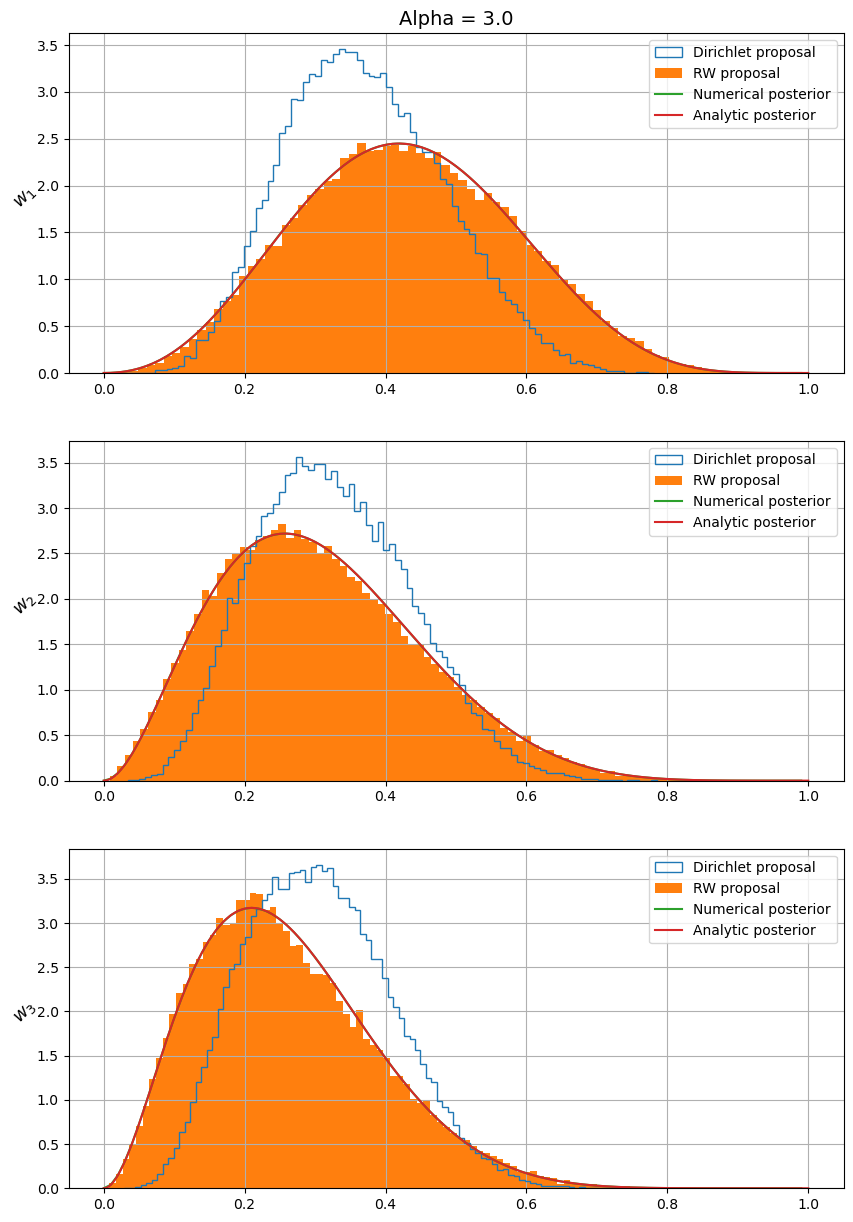

In [ ]:
fig, axs = plt.subplots( n_pars, figsize = [10,15] )
w = samples
w2 = samples2
x = np.arange(0, len(w[0]))
for i in range(n_pars):
    axs[i].hist(np.transpose(w)[i], bins = 'auto', histtype='step', density = True, label = 'Dirichlet proposal')
    axs[i].hist(np.transpose(w2)[i], bins = 'auto', density = True, label = 'RW proposal')
    axs[i].set_ylabel(f'$w_{i+1}$', rotation = 45, size = '13')
    axs[i].plot(anal_x[i], anal[i], label = 'Numerical posterior')
    if i == 0 : 
        xx = np.linspace(1e-6,1,1000)
        axs[i].plot(xx, w1_post(xx, alpha, xt), label = 'Analytic posterior')
    if i == 1 : 
        xx = np.linspace(1e-6,1,1000)
        axs[i].plot(xx, w2_post(xx, alpha, xt), label = 'Analytic posterior')
    if i == 2 : 
        xx = np.linspace(1e-6,1,1000)
        axs[i].plot(xx, w3_post(xx, alpha, xt), label = 'Analytic posterior')
    axs[i].grid()
    axs[i].legend()
    #axs[i].set_ylim([0,10])
axs[0].set_title(f'Alpha = {alpha[0]}', size = 14)
plt.savefig('Alpha'+str(alpha[0])+'.png')
plt.show()
plt.close()

Acceptance rate 0.595628:   0%|          | 101/100000 [00:00<01:39, 1006.44it/s]

[17.63084952 35.37186205 50.26752866]


Acceptance rate 0.615975:  10%|█         | 10070/100000 [00:10<01:32, 976.01it/s]

[4.75396664e-07 7.55028609e-08 5.98835901e-08]


Acceptance rate 0.617573:  20%|██        | 20084/100000 [00:20<01:22, 968.81it/s] 

[2.14305446e-21 4.78872922e-22 1.94234256e-22]


Acceptance rate 0.619764:  30%|███       | 30175/100000 [00:30<01:12, 956.69it/s] 

[5.91240769e-12 4.68942542e-14 6.28941039e-13]


Acceptance rate 0.617761:  40%|████      | 40107/100000 [00:41<01:00, 996.28it/s] 

[1.52689502e-06 2.64405256e-07 3.91054103e-07]


Acceptance rate 0.617438:  50%|█████     | 50132/100000 [00:52<00:52, 957.96it/s] 

[7.64386195e-11 1.27852023e-11 5.37968727e-11]


Acceptance rate 0.617665:  60%|██████    | 60175/100000 [01:02<00:41, 962.74it/s] 

[1.50083295e-14 1.51615051e-14 7.83693829e-15]


Acceptance rate 0.616379:  70%|███████   | 70139/100000 [01:12<00:30, 968.18it/s] 

[5.86327714e-08 3.79722142e-07 6.55852635e-08]


Acceptance rate 0.617201:  80%|████████  | 80168/100000 [01:23<00:19, 1023.09it/s]

[1.38093184e-09 6.82187631e-12 3.58449095e-11]


Acceptance rate 0.616801:  90%|█████████ | 90127/100000 [01:33<00:09, 996.08it/s] 

[0.02170672 0.0047829  0.00301002]


100%|██████████| 100/100 [00:00<00:00, 400.45it/s]


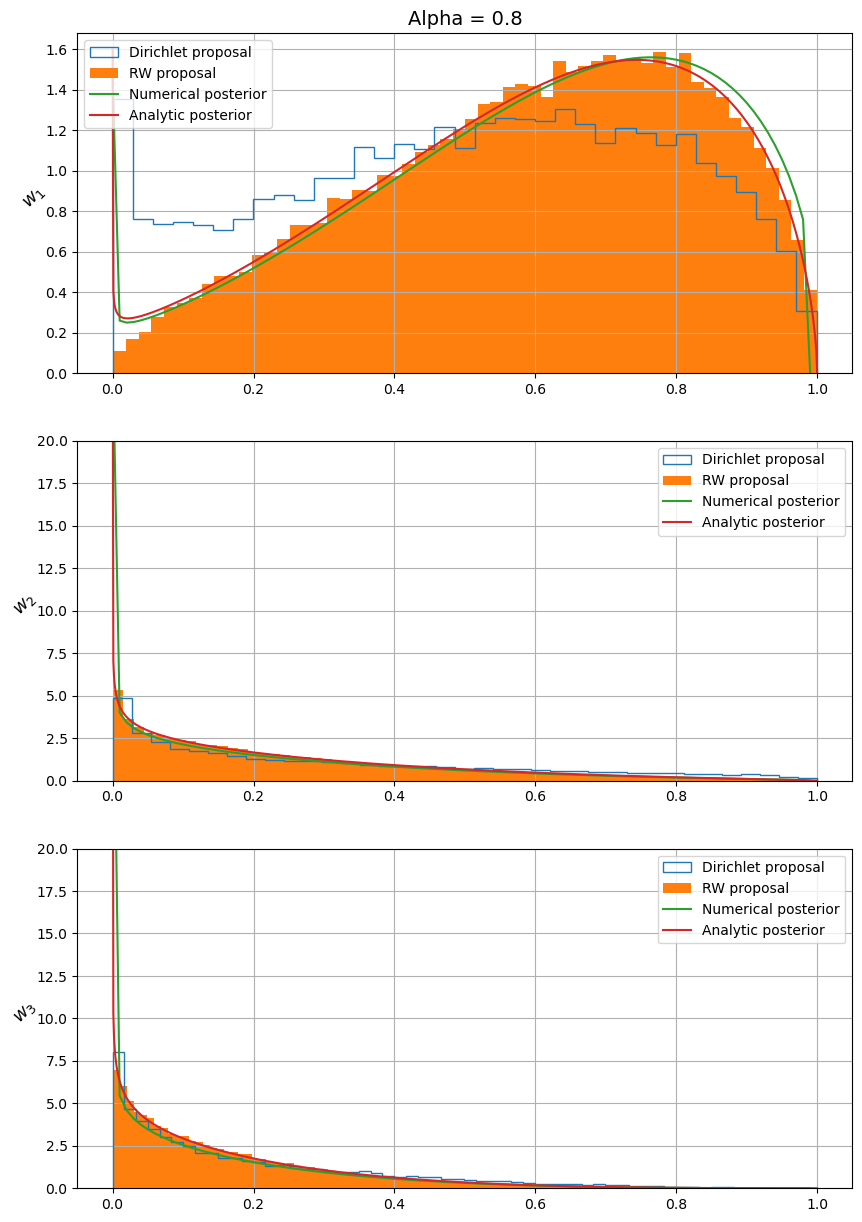

Acceptance rate 0.568282:   0%|          | 131/100000 [00:00<01:16, 1299.09it/s]

[30.57781166 19.82389032 55.63325276]


Acceptance rate 0.618787:  10%|█         | 10239/100000 [00:08<01:09, 1286.87it/s]

[7.23962503e-14 6.15993433e-15 6.75573931e-14]


Acceptance rate 0.622523:  20%|██        | 20142/100000 [00:15<01:02, 1273.04it/s]

[1.72605202e-12 5.07336679e-12 3.32540641e-12]


Acceptance rate 0.624917:  30%|███       | 30117/100000 [00:23<00:54, 1275.20it/s]

[4.50969004e-14 1.46404917e-13 1.62283859e-14]


Acceptance rate 0.623720:  40%|████      | 40181/100000 [00:31<00:46, 1278.96it/s]

[4.81185017e-10 1.72333229e-10 2.56166247e-11]


Acceptance rate 0.624891:  50%|█████     | 50185/100000 [00:39<00:38, 1284.42it/s]

[1.10140402e-13 2.43768296e-14 9.76468091e-15]


Acceptance rate 0.624105:  60%|██████    | 60129/100000 [00:47<00:31, 1264.15it/s]

[3.45005910e-14 3.39979891e-14 1.42119074e-14]


Acceptance rate 0.624452:  70%|███████   | 70127/100000 [00:55<00:23, 1261.34it/s]

[2.84163052e-11 1.76609180e-11 1.72481338e-12]


Acceptance rate 0.625375:  80%|████████  | 80185/100000 [01:03<00:15, 1238.75it/s]

[1.66837224e-14 2.96609348e-15 1.43612764e-14]


Acceptance rate 0.624443:  90%|█████████ | 90172/100000 [01:11<00:07, 1247.14it/s]

[8.46781973e-04 2.38083831e-04 4.34862917e-06]


100%|██████████| 100/100 [00:00<00:00, 603.47it/s]


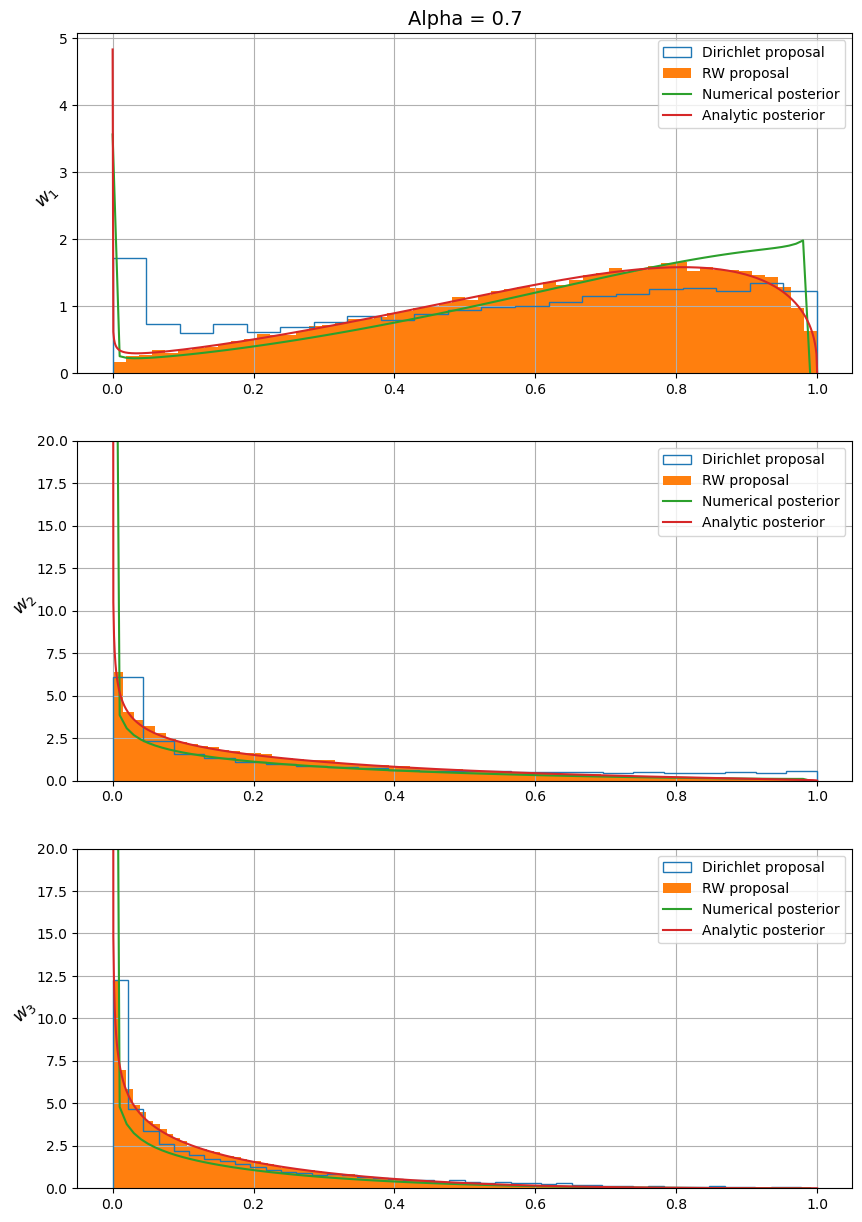

Acceptance rate 0.639485:   0%|          | 126/100000 [00:00<01:19, 1249.95it/s]

[38.08304208 36.31944801 10.90907656]


Acceptance rate 0.620919:  10%|█         | 10138/100000 [00:08<01:11, 1265.47it/s]

[0.0008154  0.00111403 0.00051131]


Acceptance rate 0.625117:  20%|██        | 20116/100000 [00:16<01:04, 1236.99it/s]

[7.91180712e-08 1.47288482e-07 2.09037335e-07]


Acceptance rate 0.629782:  30%|███       | 30184/100000 [00:24<00:54, 1275.16it/s]

[1.06057974e-18 8.75312181e-20 9.01153336e-20]


Acceptance rate 0.629682:  40%|████      | 40179/100000 [00:32<00:47, 1263.00it/s]

[6.82921890e-14 1.99149138e-14 1.14621844e-15]


Acceptance rate 0.630047:  50%|█████     | 50229/100000 [00:40<00:40, 1241.57it/s]

[6.38110337e-17 2.88712140e-17 4.54315466e-17]


Acceptance rate 0.630497:  60%|██████    | 60197/100000 [00:48<00:32, 1241.16it/s]

[5.56380607e-25 5.53492704e-24 1.12873167e-25]


Acceptance rate 0.631389:  70%|███████   | 70102/100000 [00:56<00:24, 1231.53it/s]

[5.62058139e-16 2.21391411e-17 9.42811997e-18]


Acceptance rate 0.631079:  80%|████████  | 80116/100000 [01:04<00:16, 1239.64it/s]

[6.94703816e-07 1.43968978e-07 4.73649928e-09]


Acceptance rate 0.631202:  90%|█████████ | 90099/100000 [01:12<00:07, 1246.07it/s]

[2.78337996e-08 1.34314272e-09 7.71206184e-09]


100%|██████████| 100/100 [00:00<00:00, 593.63it/s]


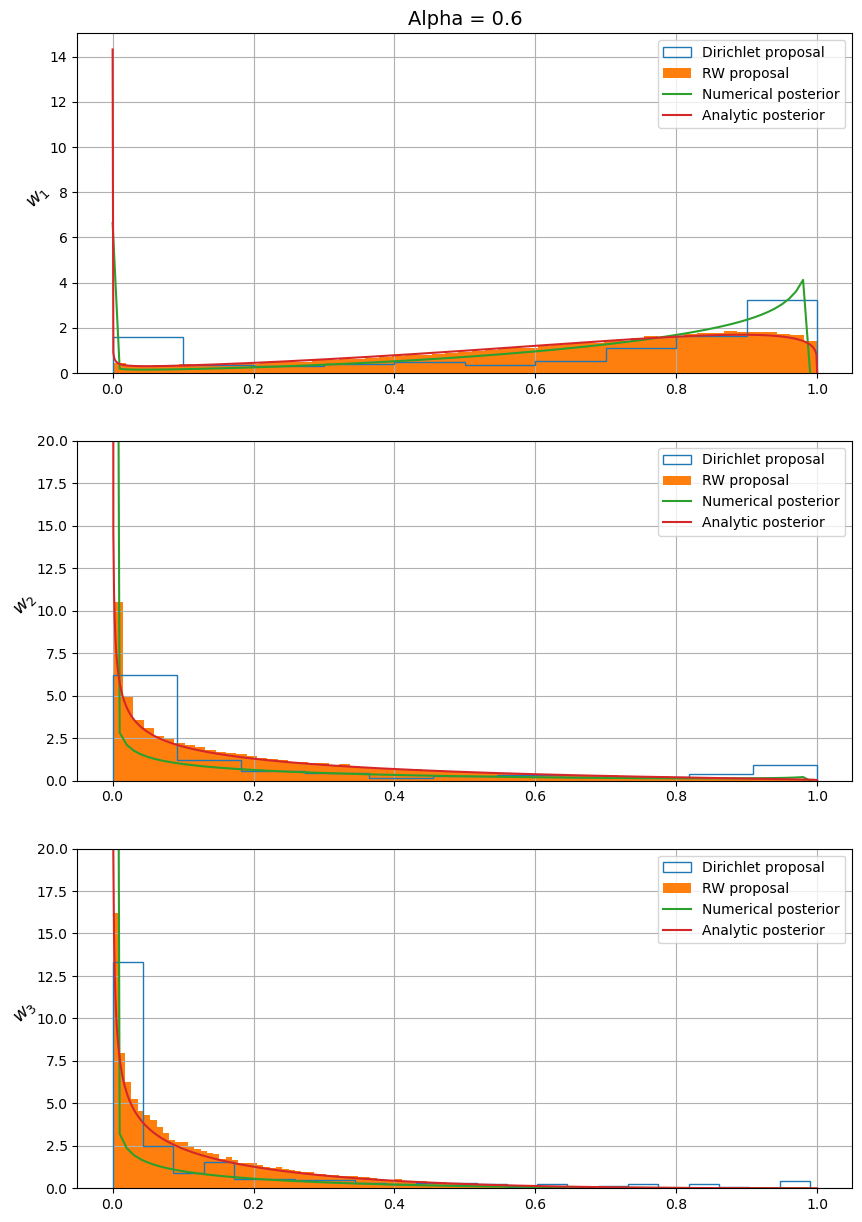

In [143]:
for a in [0.8, 0.7, 0.6]:
    #a = 2
    alpha = np.ones(n_pars)*a

    n = int(1e5)

    samples = sampling(n, xt, alpha)
    eps = 0.5
    each = int(1e4)
    samples2 = sampling2(n, xt, alpha, eps, each)

    anal_x = []
    anal = []
    for i in range(n_pars):
        x,y = an_post(i, 100, xt, alpha)
        anal_x.append(x)
        anal.append(y)

    fig, axs = plt.subplots( n_pars, figsize = [10,15] )
    w = samples
    w2 = samples2
    x = np.arange(0, len(w[0]))
    for i in range(n_pars):
        axs[i].hist(np.transpose(w)[i], bins = 'auto', histtype='step', density = True, label = 'Dirichlet proposal')
        axs[i].hist(np.transpose(w2)[i], bins = 'auto', density = True, label = 'RW proposal')
        axs[i].set_ylabel(f'$w_{i+1}$', rotation = 45, size = '13')
        axs[i].plot(anal_x[i], anal[i], label = 'Numerical posterior')
        if i == 0 : 
            xx = np.linspace(1e-6,1,1000)
            axs[i].plot(xx, w1_post(xx, alpha, xt), label = 'Analytic posterior')
        if i == 1 : 
            xx = np.linspace(1e-6,1,1000)
            axs[i].plot(xx, w2_post(xx, alpha, xt), label = 'Analytic posterior')
        if i == 2 : 
            xx = np.linspace(1e-6,1,1000)
            axs[i].plot(xx, w3_post(xx, alpha, xt), label = 'Analytic posterior')
        axs[i].grid()
        axs[i].legend()
        if i > 0 : axs[i].set_ylim([0,20])
    axs[0].set_title(f'Alpha = {alpha[0]}', size = 14)
    plt.savefig('Alpha'+str(alpha[0])+'.png')
    plt.show()
    plt.close()

